# Recurrent Convolution Strategies for Face Manipulation Detection in Videos: Model Implementation

In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../common')
import dataset_util

Make the model.

In [2]:
FACE_SIZE = 224
model = keras.models.Sequential([
    keras.Input(shape=(None, FACE_SIZE, FACE_SIZE, 1)),
    keras.layers.ConvLSTM2D(filters=40, kernel_size=(3, 3), padding='same',
                            return_sequences=True),
    keras.layers.BatchNormalization(),
    keras.layers.ConvLSTM2D(filters=40, kernel_size=(3, 3), padding='same',
                            return_sequences=True),
    keras.layers.BatchNormalization(),
    keras.layers.ConvLSTM2D(filters=40, kernel_size=(3, 3), padding='same',
                            return_sequences=True),
    keras.layers.BatchNormalization(),
    
])
model.compile(loss="binary_crossentropy", optimizer="adadelta")

Feed some data to the model. First, get dataframe.

In [3]:
dataset = dataset_util.Dataset(dataset_root='../input/faceforensics', dataset_type='faceforensics')
df = dataset.get_metadata_dataframe()
df

,label,root_dir
469.mp4,REAL,../input/faceforensics/original_sequences/yout...
481.mp4,REAL,../input/faceforensics/original_sequences/yout...
585.mp4,REAL,../input/faceforensics/original_sequences/yout...
599.mp4,REAL,../input/faceforensics/original_sequences/yout...
13__walking_down_indoor_hall_disgust.mp4,REAL,../input/faceforensics/original_sequences/acto...
09__walking_down_street_outside_angry.mp4,REAL,../input/faceforensics/original_sequences/acto...
13__talking_against_wall.mp4,REAL,../input/faceforensics/original_sequences/acto...
07__talking_against_wall.mp4,REAL,../input/faceforensics/original_sequences/acto...
469_481.mp4,FAKE,../input/faceforensics/manipulated_sequences/D...
599_585.mp4,FAKE,../input/faceforensics/manipulated_sequences/D...


Fetch labels.

In [4]:
true_and_false = df['label'] == 'FAKE'
one_hot_encoded = pd.Float64Index(true_and_false)
labels = one_hot_encoded.to_numpy()[:10]
labels

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 1.])

Write a function for fetching faces from a video. (**TODO**: use STN rather than resizing the face to 40 by 40)

In [5]:
def extract_face_video(filename):
    skipped = 0
    face_extracted_video = None
    last_frame = None
    for i in range(10):
        try:
            face_coord = dataset.get_face_coords(filename, i)
            frame = dataset.crop_frame(filename, i, face_coord)
            last_frame = cv.resize(frame, (FACE_SIZE, FACE_SIZE))
            for _ in range(skipped + 1):
                if face_extracted_video is None:
                    face_extracted_video = np.expand_dims(last_frame, axis=0)
                else:
                    face_extracted_video = np.append(
                        face_extracted_video,
                        np.expand_dims(last_frame, axis=0),
                        axis=0
                    )
            skipped = 0
        except ValueError:
            if last_frame is not None:
                face_extracted_video = np.append(
                    face_extracted_video,
                    np.expand_dims(last_frame, axis=0), axis=0)
            else:
                skipped += 1
        print('.', end='')
    print()
    return face_extracted_video

Now, extract face frames from 10 first videos in dataset.

In [6]:
inputs = None
filenames = df.index.to_list()[:10]
for filename in filenames:
    print(f'Processing video {filename}', end='')
    extracted_face_frame = extract_face_video(filename)
    if inputs is None:
        inputs = np.expand_dims(extracted_face_frame, axis=0)
        continue
    inputs = np.append(inputs, np.expand_dims(extracted_face_frame, axis=0), axis=0)

Processing video 469.mp4..........
Processing video 481.mp4..........
Processing video 585.mp4..........
Processing video 599.mp4..........
Processing video 13__walking_down_indoor_hall_disgust.mp4..........
Processing video 09__walking_down_street_outside_angry.mp4..........
Processing video 13__talking_against_wall.mp4..........
Processing video 07__talking_against_wall.mp4..........
Processing video 469_481.mp4..........
Processing video 599_585.mp4..........


As a sanity check, determine the shape of `inputs`.

In [7]:
inputs.shape

(10, 10, 224, 224, 3)

Plot them.

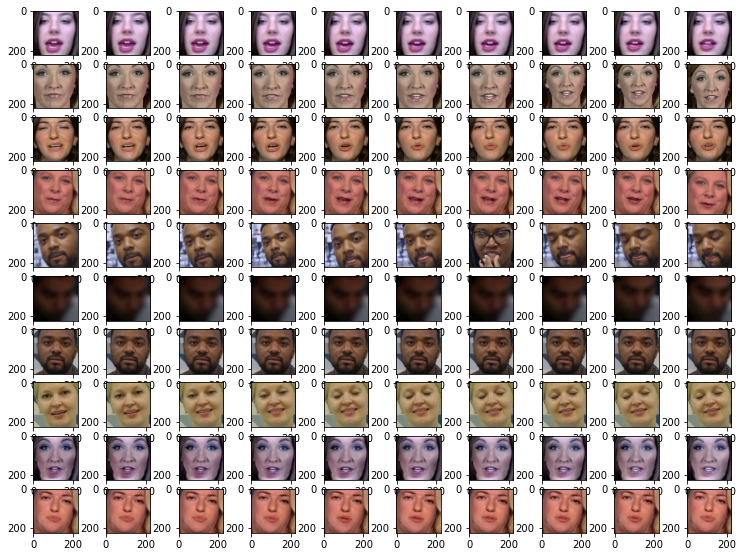

In [8]:
plt.figure(figsize=(12.8, 9.6))
for i in range(10):
    for j in range(10):
        plt.subplot(10, 10, i * 10 + j + 1)
        plt.imshow(cv.cvtColor(inputs[i][j], cv.COLOR_BGR2RGB))
plt.show()